<a href="https://colab.research.google.com/github/FadiKais1/Deep-Learning-Projects/blob/main/DL_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Assignment #1
## Submission date: 03/12/2025, 23:59.
### Topics:
- Logistic Regression
- Feedforward Neural Networks
- Backpropagation
- Optimization
- Batch Normalization

**Submitted by:**

- **Student 1 (Name, ID)**
- **Student 2 (Name, ID)**  


**Assignment Instruction:**

· Submissions are in **pairs only**. Write both names + IDs at the top of the notebook.

· Keep your code **clean, concise, and readable**.

· You may work in your IDE, but you **must** paste the final code back into the **matching notebook cells** and run it there.  


· <font color='red'>Write your textual answers in red.</font>  
(e.g., `<span style="color:red">your answer here</span>`)

· All figures, printed results, and outputs should remain visible in the notebook.  
Run **all cells** before submitting and **do not clear outputs**.

· Use relative paths — **no absolute file paths** pointing to local machines.

· **Important:** Your submission must be entirely your own.  
Any form of plagiarism (including uncredited use of ChatGPT or AI tools) will result in **grade 0** and disciplinary action.


In [ ]:
# --- Global Setup ---

import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.init as init

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


## Question 1 — From Classic ML to Deep Networks

In this question we embark on a short expedition from classic Machine Learning to Deep Learning.

We will compare the performance of a **multiclass logistic regression** to a **multi-layer perceptron (MLP)** on the **MNIST** dataset.


Start by running this cell which includes relative setup and useful helper functions implemented for you to use.

In [ ]:
# --- Define Seed ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Helper Functions To Use ---
def accuracy(logits: torch.Tensor, y: torch.Tensor):
    """Top-1 accuracy for logits [N,C] and labels [N]."""
    return (logits.argmax(dim=1) == y).float().mean().item()

def count_params(obj):
    """
    Count trainable parameters.
    - If obj is (W, b) tuple → counts elements.
    - If obj is a nn.Module → sums requires_grad params.
    """
    if isinstance(obj, tuple) and len(obj) == 2:
        W, b = obj
        return W.numel() + b.numel()
    if isinstance(obj, nn.Module):
        return sum(p.numel() for p in obj.parameters() if p.requires_grad)
    raise TypeError("count_params expects (W,b) or nn.Module.")


@torch.no_grad()
def evaluate_acc(W: torch.Tensor, b: torch.Tensor, loader):
    """Dataset-level accuracy for a linear softmax model parameterized by (W,b)."""
    total_acc, total_n = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(DEVICE).view(xb.size(0), -1)
        yb = yb.to(DEVICE)
        logits = xb @ W + b
        batch_acc = accuracy(logits, yb)
        n = xb.size(0)
        total_acc += batch_acc * n         # weight by batch size
        total_n   += n
    return total_acc / total_n


# Use this function in the training loop for your nn.Module
@torch.no_grad()
def evaluate_module(model: nn.Module, loader):
    model.eval()
    total_acc, total_n = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        batch_acc = accuracy(logits, yb)
        n = xb.size(0)
        total_acc += batch_acc * n
        total_n   += n
    return total_acc / total_n

### Load & Preprocess the Data:



We first load the MNIST dataset as provided by `torchvision`. All images are automatically converted to tensors in the range $[0,1]$.


In [ ]:
# Load the raw MNIST dataset
transform = transforms.ToTensor()

train_full = datasets.MNIST(root="./data", train=True,  download=True, transform=transform)
test_set   = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

print(f"\n Train set: {len(train_full)} samples  |  Test set: {len(test_set)} samples")

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 507kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.86MB/s]


 Train set: 60000 samples  |  Test set: 10000 samples


Implement the following steps:

1. **Split the data:**
   - The MNIST test set is already provided.
   - From the full training set, create an 80/20 split into **train** and **validation** subsets.

2. **Construct `DataLoader` objects:**
   - `train_loader` → use shuffling.
   - `val_loader` → no shuffling.
   - `test_loader` → no shuffling.2.

3. **Print a quick sanity check:**
   - batch shapes `(batch_size = 128, 1, 28, 28)`
   - label range (0–9)

*Example format:*
```python
Batch: torch.Size([128, 1, 28, 28]) torch.Size([128]) | pixel range = (0.0, 1.0)


In [ ]:



transform = transforms.ToTensor()

train_full = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_set = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print(f"\nTrain set: {len(train_full)} samples  |  Test set: {len(test_set)} samples")

# Create Train/Validation Splits: 80% for training, 20% for validation.
train_size = int(0.8 * len(train_full))
val_size   = len(train_full) - train_size

train_set, val_set = random_split(train_full, [train_size, val_size])

# Create DataLoaders
BATCH = 128
train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True)

# validation and test loaders do NOT shuffle
val_loader = DataLoader(val_set, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH, shuffle=False)

# Sanity Check
# Take one batch from the training loader
xb, yb = next(iter(train_loader))

print("Batch images shape:", xb.shape)
print("Batch labels shape:", yb.shape)
print("Pixel value range:", (xb.min().item(), xb.max().item()))



Train set: 60000 samples  |  Test set: 10000 samples
Batch images shape: torch.Size([128, 1, 28, 28])
Batch labels shape: torch.Size([128])
Pixel value range: (0.0, 1.0)


###  Multiclass Logistic Regression



In binary logistic regression, we model  
$$
P(y=1 \mid x) = \sigma(w^\top x + b)
$$
where  $\sigma$ is the sigmoid activation function.

For **multiclass** problems, like ours where MNIST is a dataset of images of 10 digits, hence 10 classes, we generalize this idea.

Each class $c \in \{0, \dots, 9\}$ has its own weight vector  $w_c$ and bias  $b_c$.

We stack them into a **weight matrix**  $W \in \mathbb{R}^{d \times C}$
and a **bias vector**  $b \in \mathbb{R}^{C}$.

<br>

Generally speaking, we compute a forward pass by computing:

$$
z_i = W^\top x_i + b
$$

where $W \in \mathbb{R}^{d \times C}$ is the weight matrix and $b \in \mathbb{R}^C$ is the bias vector.

<br>

We then obtain class probabilities via the softmax function:

$$
p_i(c) = \frac{e^{z_i(c)}}{\sum_{k=1}^{C} e^{z_i(k)}}
$$

The model is trained by minimizing the **cross-entropy loss** between the predicted probabilities and the true class labels:

$$
\mathcal{L}(W,b) = -\frac{1}{N} \sum_{i=1}^N \log p_i(y_i)
$$

and the parameters are updated using **gradient descent**:

$$
W \leftarrow W - \eta \, \nabla_W \mathcal{L}, \qquad
b \leftarrow b - \eta \, \nabla_b \mathcal{L}
$$


<br><br>
In this question, you will build a multiclass logistic regression model from scratch, train it using the cross-entropy loss, and optimize it with gradient descent.

<br>

You will then evaluate the model’s performance on the MNIST dataset, and train it on 20 epochs.


In [ ]:
def logistic_regression(train_loader, val_loader, epochs=20, lr=0.1, tol=1e-6):
    """
    Train a multiclass logistic regression model using gradient descent.
    - X: [N, d] input features (flattened images)
    - y: [N] class labels in {0,...,9}
    - lr: learning rate
    - max_steps: max number of iterations
    - tol: stop early when gradients converge

    Returns: (W, b)
    """

    # 1. Initialize model parameters
    input_dim = 28 * 28
    num_classes = 10

    W = torch.randn(input_dim, num_classes, device=DEVICE, requires_grad=True)
    b = torch.zeros(num_classes, device=DEVICE, requires_grad=True)

    with torch.no_grad():
        W *= 0.01

    print("Training multiclass logistic regression...\n")

    # 2. Training loop
    for epoch in range(epochs):
        total_loss = 0
        total_samples = 0

        for xb, yb in train_loader:
            xb = xb.to(DEVICE).view(xb.size(0), -1)
            yb = yb.to(DEVICE)

            logits = xb @ W + b

            loss = F.cross_entropy(logits, yb)

            loss.backward()

            # Gradient descent update
            with torch.no_grad():
                grad_norm = W.grad.norm().item()

                if grad_norm < tol:
                    print(f"Early stopping at epoch {epoch+1} (gradient norm < tol).")
                    return W, b

                # update parameters
                W -= lr * W.grad
                b -= lr * b.grad

                # reset gradients to zero
                W.grad.zero_()
                b.grad.zero_()

            total_loss += loss.item() * xb.size(0)
            total_samples += xb.size(0)

        avg_loss = total_loss / total_samples

        train_acc = evaluate_acc(W, b, train_loader)
        val_acc   = evaluate_acc(W, b, val_loader)

        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} "
              f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    print("\nTraining completed.")
    return W, b


Now run the next cell to evaluate your multiclass logistic regression.

We use the `evaluate_acc` helper function to evaluate.


In [ ]:
# TODO: Run
W, b = logistic_regression(train_loader, val_loader, epochs=20, lr=0.1)

model = (W, b)

# Evaluate
val_acc  = evaluate_acc(W, b, val_loader)
test_acc = evaluate_acc(W, b, test_loader)

print(f"\nNumber of Parameters: {count_params(model):,}")
print(f"Val. acc.: {val_acc:.4f}")
print(f"Test acc.: {test_acc:.4f}")

Training multiclass logistic regression...

Epoch 01 | Loss: 0.6102 | Train Acc: 0.8900 | Val Acc: 0.8857
Epoch 02 | Loss: 0.3871 | Train Acc: 0.9026 | Val Acc: 0.8958
Epoch 03 | Loss: 0.3514 | Train Acc: 0.9068 | Val Acc: 0.9006
Epoch 04 | Loss: 0.3328 | Train Acc: 0.9107 | Val Acc: 0.9037
Epoch 05 | Loss: 0.3206 | Train Acc: 0.9134 | Val Acc: 0.9051
Epoch 06 | Loss: 0.3119 | Train Acc: 0.9154 | Val Acc: 0.9075
Epoch 07 | Loss: 0.3055 | Train Acc: 0.9176 | Val Acc: 0.9086
Epoch 08 | Loss: 0.3001 | Train Acc: 0.9181 | Val Acc: 0.9097
Epoch 09 | Loss: 0.2956 | Train Acc: 0.9192 | Val Acc: 0.9099
Epoch 10 | Loss: 0.2920 | Train Acc: 0.9206 | Val Acc: 0.9107
Epoch 11 | Loss: 0.2889 | Train Acc: 0.9212 | Val Acc: 0.9117
Epoch 12 | Loss: 0.2861 | Train Acc: 0.9220 | Val Acc: 0.9113
Epoch 13 | Loss: 0.2838 | Train Acc: 0.9224 | Val Acc: 0.9126
Epoch 14 | Loss: 0.2812 | Train Acc: 0.9234 | Val Acc: 0.9138
Epoch 15 | Loss: 0.2794 | Train Acc: 0.9225 | Val Acc: 0.9128
Epoch 16 | Loss: 0.2776 | 

Answer the following questions:

1. Is a *logistic regression* a sufficient model for this task?  
   What **constraints** does this model impose on the decision boundaries and on what it can “represent”?  
   What **modification** might help address these constraints?


2. Give two examples of incorrectly classified digits. Include the image of the misclassified digit,
the predicted class and the actual class in your write up

</br>

<font color='red'>Write your answers here for questions above, with an explaination as requested.</font>

<font color='red'> Answer for 1:</font>

<font color='red'>-  Logistic regression is good, but not fully sufficient for MNIST.
It learns a linear classifier, meaning that it tries to separate all 10 digit classes by straight hyperplanes in the 784-dimensional input space.
Even though it performs surprisingly well (around 92% accuracy, like your model), MNIST digits are not perfectly linearly separable.
For real-world handwritten digits, the shapes can bend, curve, shift, and vary in writing style — and a single linear decision boundary is often not expressive enough.
So:It works, but It cannot capture more complex patterns the way neural networks can.<font>

<font color='red'>-  Logistic regression can only learn linear decision boundaries.       That means:

  <font color='red'>* The prediction is always of the form:
  logits=WTx+b
  logits=W
  T
  x+b
  No interactions, no hierarchy, no nonlinear transformations.

  <font color='red'>*  Decision boundaries are linear hyperplanes
  This forces the model to represent each digit class as something that can be separated by a straight boundary in pixel space.
  But MNIST digits are curvy, rotated, shifted, or even broken — and they overlap heavily in raw pixel space.

  <font color='red'>*  What this limits: Can't recognize nonlinear patterns
  Can't detect local features like curves, corners, strokes
  Sensitive to slight translations (e.g., same digit shifted by 1 pixel → different prediction)
  Cannot handle variations in handwriting style
  So the key constraint is: no nonlinearity → no complex shapes → no flexible decision boundaries.

<font color='red'> - Logistic regression is limited because it can only learn straight-line (linear) boundaries, and handwritten digits are much more complicated than that. A good way to fix this is to use a model that can learn nonlinear patterns. For example, adding a hidden layer with an activation function like ReLU allows the model to “bend” the decision boundaries and understand more complex shapes. An even better improvement is to use a Convolutional Neural Network (CNN), which is designed for images and can recognize edges, curves, and small details in the digits. These changes let the model learn much richer patterns and usually give much higher accuracy than basic logistic regression.


<font color='red'> Answer for 2:

<font color='red'> - Example 1
Predicted: 6
Actual: 5

<font color='red'> - Example 2
Predicted: 6
Actual: 4

<font color='red'>the images will appear dow below after the code for it.



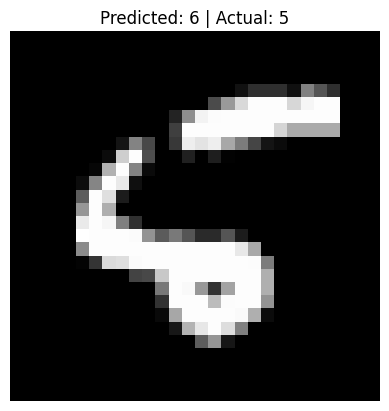

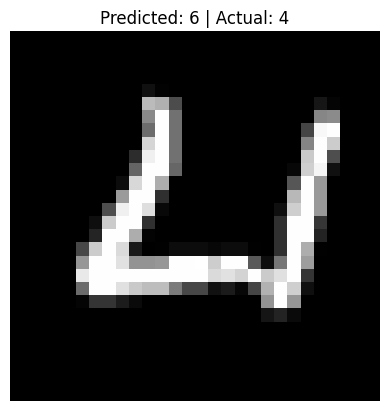

In [ ]:
import matplotlib.pyplot as plt

def show_misclassified(W, b, loader, num_examples=2):
    examples = 0

    for xb, yb in loader:
        xb_flat = xb.to(DEVICE).view(xb.size(0), -1)
        yb = yb.to(DEVICE)

        logits = xb_flat @ W + b
        preds = logits.argmax(dim=1)

        mismatches = preds != yb

        idxs = mismatches.nonzero(as_tuple=True)[0]

        for idx in idxs:
            if examples >= num_examples:
                return

            img = xb[idx].squeeze().cpu()
            true_label = int(yb[idx].item())
            pred_label = int(preds[idx].item())

            plt.imshow(img, cmap="gray")
            plt.title(f"Predicted: {pred_label} | Actual: {true_label}")
            plt.axis("off")
            plt.show()

            examples += 1

# Example: show 2 wrong predictions from test data
show_misclassified(W, b, test_loader, num_examples=2)


### Feedforward Neural Network




As we learned in class, a **Feedforward Neural Network (FFNN)** maps an input — in our case, a flattened $28 \times 28$ image, $x \in \mathbb{R}^{784}$ — through a sequence of **linear layers** interleaved with **nonlinear activation functions**.

Formally, the computation proceeds as follows:

$$
y^{(1)} = \sigma (W^{(1)}x+b^{(1)})
$$
$$
y^{(\ell)} = \sigma (W^{(1)}y^{(\ell -1)}+b^{(1)})
$$


Where:
- $y^{(i)}$ is the output of layer $i$.
- $W^{(i)}$ and $b^{(i)}$ are the weight matrix and bias vector for layer $i$, respectively.
- $\sigma ^{(i)}$ is the activation function used in layer $i$.

In this section you will implement a FFNN from scratch, and see how it fairs with the MNIST dataset.

In the cell below, implement your `MLP` network, a two-layer Multi-Layer Perceptron with no regularization to classify MNIST with the following architecture:

- Input layer : 784 nodes (MNIST images size)
- First hidden layer : 400 nodes
- Second hidden layer : 400 nodes
- Output layer : 10 nodes (number of classes for MNIST)


<br>

- Use `RELU()` as your activation function for each layer.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),

            nn.Linear(400, 400),
            nn.ReLU(),

            nn.Linear(400, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


After defining `MLP` class, train it for **20 epochs** using **cross-entropy loss** and **Adam** as your optimizer.  

At the end of every epoch, evaluate the model both on the training set and on the validation set. You should print the loss, the training accuracy, and the validation accuracy so that you can monitor how the model improves over time and detect potential overfitting.

Once training is complete, produce a plot that shows how the training accuracy and the validation accuracy evolve across the 20 epochs. The plot should clearly reflect the learning dynamics of your model and allow you to compare its performance to the logistic regression model from the previous section.

> You already have the helpers `evaluate_module`, `accuracy`, and `count_params` in the setup cell— you may use them directly in your implementation.


Training MLP...

Epoch 01 | Loss: 0.3200 | Train Acc: 0.9619 | Val Acc: 0.9522
Epoch 02 | Loss: 0.1153 | Train Acc: 0.9783 | Val Acc: 0.9669
Epoch 03 | Loss: 0.0714 | Train Acc: 0.9855 | Val Acc: 0.9700
Epoch 04 | Loss: 0.0524 | Train Acc: 0.9902 | Val Acc: 0.9748
Epoch 05 | Loss: 0.0375 | Train Acc: 0.9907 | Val Acc: 0.9725
Epoch 06 | Loss: 0.0271 | Train Acc: 0.9950 | Val Acc: 0.9760
Epoch 07 | Loss: 0.0225 | Train Acc: 0.9928 | Val Acc: 0.9728
Epoch 08 | Loss: 0.0212 | Train Acc: 0.9966 | Val Acc: 0.9764
Epoch 09 | Loss: 0.0140 | Train Acc: 0.9955 | Val Acc: 0.9728
Epoch 10 | Loss: 0.0158 | Train Acc: 0.9962 | Val Acc: 0.9758
Epoch 11 | Loss: 0.0125 | Train Acc: 0.9964 | Val Acc: 0.9768
Epoch 12 | Loss: 0.0132 | Train Acc: 0.9954 | Val Acc: 0.9741
Epoch 13 | Loss: 0.0105 | Train Acc: 0.9974 | Val Acc: 0.9770
Epoch 14 | Loss: 0.0078 | Train Acc: 0.9980 | Val Acc: 0.9768
Epoch 15 | Loss: 0.0109 | Train Acc: 0.9980 | Val Acc: 0.9793
Epoch 16 | Loss: 0.0089 | Train Acc: 0.9980 | Val Acc

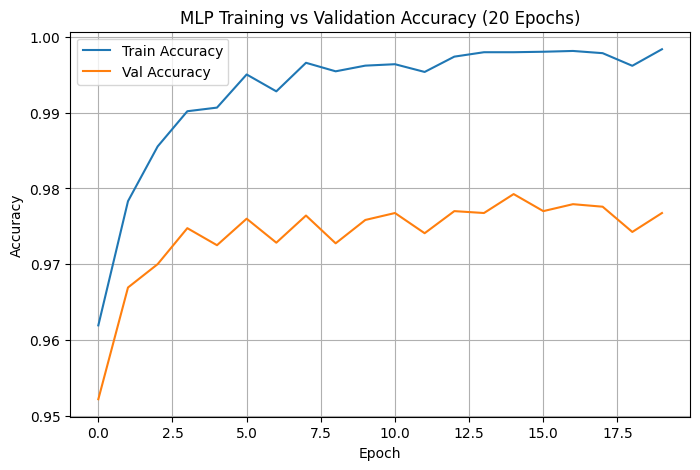

In [ ]:
# --- Train the MLP model ---

model = MLP().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20

train_acc_hist = []
val_acc_hist = []
loss_hist = []

print("Training MLP...\n")

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_samples = 0

    for xb, yb in train_loader:

        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        total_samples += xb.size(0)

    avg_loss = total_loss / total_samples

    train_acc = evaluate_module(model, train_loader)
    val_acc   = evaluate_module(model, val_loader)

    loss_hist.append(avg_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(
        f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} "
        f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

print("\nTraining complete!")
print(f"Number of Parameters: {count_params(model):,}")




plt.figure(figsize=(8,5))
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP Training vs Validation Accuracy (20 Epochs)")
plt.legend()
plt.grid(True)
plt.show()



<font color="red">Answer the following questions:</font>

<ol>
  <li>
    Using your results, explain why this model outperforms the logistic-regression baseline.
    What key property of the architecture could be tied to the success?
    Cite specific evidence from your plots or errors.
    <br>
  </li>
<br>
  <li>
    Did you need all 20 epochs? If not, choose a stopping point from the validation curve, and justify it.
    Propose a concrete rule you would use next time to limit computation waste (spell out the metric and the trigger).
    <br>
  </li>


</ol>




<font color='red'>Answer for 1:
The MLP clearly outperforms the logistic-regression model because it is able to learn non-linear relationships, while logistic regression can only learn linear decision boundaries. In our results, logistic regression reached about 92% accuracy, while the MLP reached around 99% train accuracy and 97–98% validation accuracy, which is a large improvement.
The key property that explains this success is the two hidden layers with ReLU activations. These nonlinear layers allow the model to learn curved, flexible decision boundaries and important patterns like edges, corners, and variations in handwriting. We can see this directly in the accuracy curves: the MLP’s validation accuracy quickly climbs above the logistic-regression ceiling (92%) already by epoch 2–3, and stabilizes around 97–98%, showing that the network is capturing richer features.
Also, in the training curve, the model continues improving without collapsing or diverging, which shows that the architecture is well-suited for MNIST. In contrast, logistic regression converged early and hit its natural limit because of its linear structure.
So overall, the key reason for the improvement is:
The MLP contains nonlinear layers (ReLU) that give it much higher expressive power than logistic regression.

<font color='red'>Answer for 2: Did you need all 20 epochs? Early stopping justification
From the validation accuracy curve, we can clearly see that the model reaches its best performance around epochs 8–12, where the validation accuracy stabilizes near 97.5%–98%. After that point, the validation curve fluctuates slightly but does not really improve, while the training accuracy keeps rising. This suggests that later epochs mainly increase training accuracy without helping validation accuracy — meaning we are entering the region of diminishing returns.
So no, we did not need all 20 epochs.
A reasonable stopping point would be epoch 9 or 10, when validation accuracy first reaches about 97.8%, which is basically the peak level for this model.



<font color='red'>- A concrete early-stopping rule (simple and practical)
Here is a clear stopping rule we can use next time:
Early-Stopping Rule:
we will Track validation accuracy at the end of each epoch.
and If validation accuracy does not improve for 3 consecutive epochs, so we will stop training early.
This rule saves computation and avoids overfitting without being too aggressive.

### Exploring Initialization

Now, we’ll explore how **weight initialization** affects training dynamics and accuracy. In this section, you will expirement with different initilization methods, **changing only the initialization scheme** while keeping **everything else fixed**, including the model architecture, optimizer, data splits, number of epochs, batch size, etc.

<br>

In the previous code, you used PyTorch’s default: **Kaiming/He initialization**, which scales weights so that
$$
\mathrm{Var}(W_{ij}) \approx \frac{2}{\text{fan}_{in}}
$$
to help stabilize activations and gradients with ReLU layers.

In this section, you'll compare this baseline to four alternatives:
1. Zero initialization
2. Uniform $[0,1]$
3. Standard Normal: $\mathcal{N}(0,1)$
4. Xavier initialization

For each scheme, reinitialize <strong>all</strong> linear layers (weights and biases), train for 20 epochs using adam optimizer, and record validation accuracy per epoch and the final test accuracy. Then plot all validation-accuracy curves on one figure, report the final test accuracies for each method.

> Tip: Recreate a **fresh model** for each initialization; don’t re-use trained weights between runs.


===== Training MLP with Zero Initialization =====
Epoch 01 | Val Acc: 0.1133
Epoch 02 | Val Acc: 0.1133
Epoch 03 | Val Acc: 0.1133
Epoch 04 | Val Acc: 0.1133
Epoch 05 | Val Acc: 0.1133
Epoch 06 | Val Acc: 0.1133
Epoch 07 | Val Acc: 0.1133
Epoch 08 | Val Acc: 0.1133
Epoch 09 | Val Acc: 0.1133
Epoch 10 | Val Acc: 0.1133
Epoch 11 | Val Acc: 0.1133
Epoch 12 | Val Acc: 0.1133
Epoch 13 | Val Acc: 0.1133
Epoch 14 | Val Acc: 0.1133
Epoch 15 | Val Acc: 0.1133
Epoch 16 | Val Acc: 0.1133
Epoch 17 | Val Acc: 0.1133
Epoch 18 | Val Acc: 0.1133
Epoch 19 | Val Acc: 0.1133
Epoch 20 | Val Acc: 0.1133
Final Test Accuracy (Zero): 0.1135

===== Training MLP with Uniform [0,1] Initialization =====
Epoch 01 | Val Acc: 0.4879
Epoch 02 | Val Acc: 0.8253
Epoch 03 | Val Acc: 0.7805
Epoch 04 | Val Acc: 0.8317
Epoch 05 | Val Acc: 0.7911
Epoch 06 | Val Acc: 0.8825
Epoch 07 | Val Acc: 0.8223
Epoch 08 | Val Acc: 0.8148
Epoch 09 | Val Acc: 0.7657
Epoch 10 | Val Acc: 0.7598
Epoch 11 | Val Acc: 0.8706
Epoch 12 | Val Ac

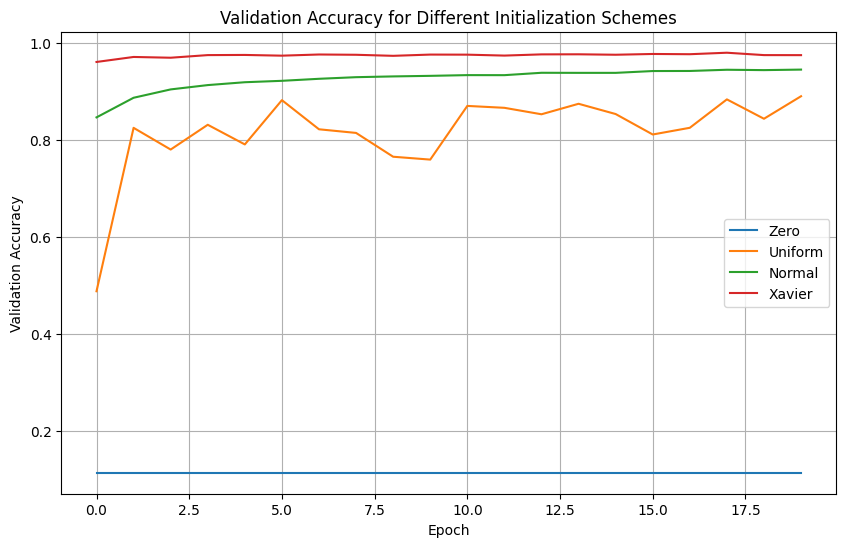


==== Final Test Accuracies ====
Zero: 0.1135
Uniform: 0.9012
Normal: 0.9486
Xavier: 0.9774


In [ ]:
# We have writted the answer solution by 1-4 steps to make it easier for solution.

#1. Helper: initialization functions
# --- Initialization schemes ---

def init_zero(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0.0)
        nn.init.constant_(m.bias, 0.0)

def init_uniform(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, a=0.0, b=1.0)
        nn.init.uniform_(m.bias, a=0.0, b=1.0)

def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=1.0)
        nn.init.normal_(m.bias, mean=0.0, std=1.0)

def init_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

#--------------------------------------------------------------------------------

#2. Helper: train model for 20 epochs with a given initialization
def train_with_init(init_fn, name):
    print(f"\n===== Training MLP with {name} Initialization =====")

    model = MLP().to(DEVICE)
    model.apply(init_fn)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    val_acc_hist = []

    for epoch in range(20):
        model.train()
        total_loss = 0
        total_samples = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            logits = model(xb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total_samples += xb.size(0)

        # record validation accuracy
        val_acc = evaluate_module(model, val_loader)
        val_acc_hist.append(val_acc)

        print(f"Epoch {epoch+1:02d} | Val Acc: {val_acc:.4f}")

    # final test accuracy
    test_acc = evaluate_module(model, test_loader)
    print(f"Final Test Accuracy ({name}): {test_acc:.4f}")

    return val_acc_hist, test_acc

#--------------------------------------------------------------------------------

#3. Run all four initialization experiments
# Store results
results = {}
test_results = {}

# Zero
val_zero, test_zero = train_with_init(init_zero, "Zero")
results["Zero"] = val_zero
test_results["Zero"] = test_zero

# Uniform [0,1]
val_uni, test_uni = train_with_init(init_uniform, "Uniform [0,1]")
results["Uniform"] = val_uni
test_results["Uniform"] = test_uni

# Standard Normal N(0,1)
val_norm, test_norm = train_with_init(init_normal, "Standard Normal")
results["Normal"] = val_norm
test_results["Normal"] = test_norm

# Xavier
val_xav, test_xav = train_with_init(init_xavier, "Xavier")
results["Xavier"] = val_xav
test_results["Xavier"] = test_xav

#--------------------------------------------------------------------------------

#4. Plotting all validation accuracy curves as required
plt.figure(figsize=(10,6))

for name, vals in results.items():
    plt.plot(vals, label=name)

plt.title("Validation Accuracy for Different Initialization Schemes")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#--------------------------------------------------------------------------------

#5. Printing final test accuracies
print("\n==== Final Test Accuracies ====")
for name, acc in test_results.items():
    print(f"{name}: {acc:.4f}")


<font color="red">Answer the following question:</font>

Why does zero initialization cause training to fail, even though the optimizer still updates the weights?

<font color="red">Anawer: Zero initialization makes training fail because all the neurons in the network become completely identical. When every weight starts at zero, all neurons in the same layer get exactly the same input, produce the same output, and also receive the same gradient during backpropagation. Because of that, they all update in the exact same way every step. In practice, this means the network never breaks the symmetry between neurons — it behaves like each layer only has one neuron instead of hundreds.
Even though the optimizer “updates” the weights, the updates are identical for every neuron, so the model can’t learn different features or representations. Instead of learning edges, curves, or patterns, the entire layer just stays stuck doing the same simple operation over and over. As a result, the accuracy stays very low and the network can’t learn anything meaningful from the data.
In short: zero initialization makes all neurons act the same, so the network can’t learn diverse features, and training basically collapses even though gradients exist.




### Exploring Optimization Methods


Finally, we’ll explore how **different Optimization** methods affect training dynamics and accuracy. In this section, you will expirement with different optimizers, **changing only the optimization method** while keeping **everything else fixed**, including the model architecture, selecting the best initialization scheme you got earlier, data splits, number of epochs, batch size, etc.

<br>

Up to this point, you used the **Adam** optimizer. Here, you will experiment with alternative optimizers and compare their performance under the same settings.

In this section, you'll compare this baseline to three other alternatives:
1. Stochastic Gradient Descent (SGD)
2. RMSProp
3. Adagrad


As you did with initilization exploring, for each optimizer, create a **fresh model** and apply the **same fixed initialization** to all `nn.Linear` layers (weights & biases). Train the model for **20 epochs**. Plot all **validation-accuracy vs. epoch** curves on one figure and compare test accuracies.

> Tip: Recreate a **fresh model** for each initialization; don’t re-use trained weights between runs.


===== Training MLP with Adam =====
Epoch 01 | Val Acc: 0.9556
Epoch 02 | Val Acc: 0.9708
Epoch 03 | Val Acc: 0.9713
Epoch 04 | Val Acc: 0.9741
Epoch 05 | Val Acc: 0.9712
Epoch 06 | Val Acc: 0.9780
Epoch 07 | Val Acc: 0.9744
Epoch 08 | Val Acc: 0.9747
Epoch 09 | Val Acc: 0.9748
Epoch 10 | Val Acc: 0.9761
Epoch 11 | Val Acc: 0.9794
Epoch 12 | Val Acc: 0.9789
Epoch 13 | Val Acc: 0.9781
Epoch 14 | Val Acc: 0.9746
Epoch 15 | Val Acc: 0.9783
Epoch 16 | Val Acc: 0.9768
Epoch 17 | Val Acc: 0.9768
Epoch 18 | Val Acc: 0.9808
Epoch 19 | Val Acc: 0.9792
Epoch 20 | Val Acc: 0.9751
Final Test Accuracy (Adam): 0.9762

===== Training MLP with SGD =====
Epoch 01 | Val Acc: 0.8493
Epoch 02 | Val Acc: 0.8796
Epoch 03 | Val Acc: 0.8932
Epoch 04 | Val Acc: 0.8997
Epoch 05 | Val Acc: 0.9058
Epoch 06 | Val Acc: 0.9113
Epoch 07 | Val Acc: 0.9152
Epoch 08 | Val Acc: 0.9189
Epoch 09 | Val Acc: 0.9210
Epoch 10 | Val Acc: 0.9247
Epoch 11 | Val Acc: 0.9267
Epoch 12 | Val Acc: 0.9296
Epoch 13 | Val Acc: 0.9320
Epo

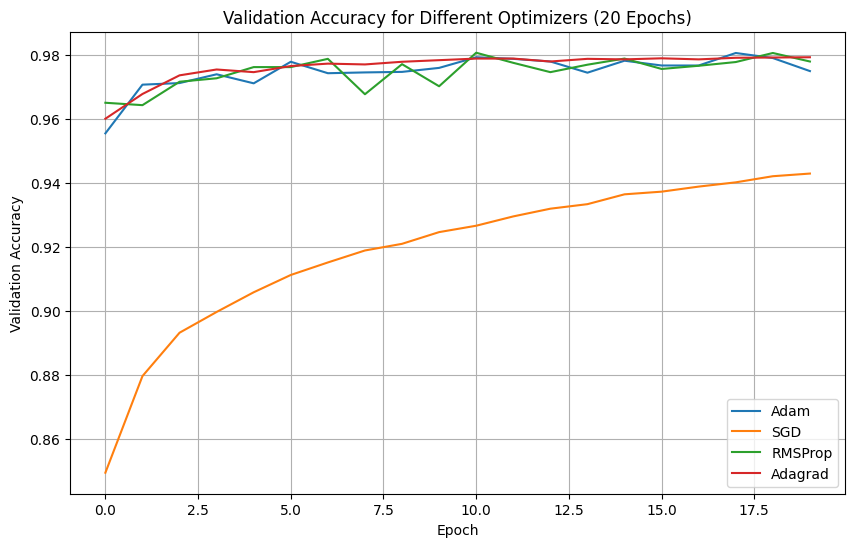


===== Final Test Accuracies by Optimizer =====
Adam: 0.9762
SGD: 0.9506
RMSProp: 0.9814
Adagrad: 0.9822


In [ ]:
def fixed_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)


def train_with_optimizer(optimizer_name):
    print(f"\n===== Training MLP with {optimizer_name} =====")

    # fresh model each time as you writed in the top
    model = MLP().to(DEVICE)
    model.apply(fixed_init)

    criterion = nn.CrossEntropyLoss()

    # choose optimizer
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == "RMSProp":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer_name == "Adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
    else:
        raise ValueError("Unknown optimizer")

    val_acc_hist = []

    # training loop
    for epoch in range(20):
        model.train()
        total_loss = 0
        total_samples = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            logits = model(xb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            total_samples += xb.size(0)

        # validation accuracy
        val_acc = evaluate_module(model, val_loader)
        val_acc_hist.append(val_acc)

        print(f"Epoch {epoch+1:02d} | Val Acc: {val_acc:.4f}")

    # final test accuracy
    test_acc = evaluate_module(model, test_loader)
    print(f"Final Test Accuracy ({optimizer_name}): {test_acc:.4f}")

    return val_acc_hist, test_acc


optimizers = ["Adam", "SGD", "RMSProp", "Adagrad"]

results_opt = {}
test_opt = {}

for opt in optimizers:
    val_hist, test_acc = train_with_optimizer(opt)
    results_opt[opt] = val_hist
    test_opt[opt] = test_acc



plt.figure(figsize=(10,6))

for name, vals in results_opt.items():
    plt.plot(vals, label=name)

plt.title("Validation Accuracy for Different Optimizers (20 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()



print("\n===== Final Test Accuracies by Optimizer =====")
for name, acc in test_opt.items():
    print(f"{name}: {acc:.4f}")



#### Reflection

Consider the interaction between initialization and optimization:

- Combine the **best-performing initialization** with the **worst-performing optimizer**.
- Combine the **worst-performing initialization** with the **best-performing optimizer**.

Run both experiments and compare the learning dynamics.




=== Experiment 1: Xavier Initialization + SGD Optimizer ===
Epoch 01 | Loss: 462.3801 | Train Acc: 0.8532 | Val Acc: 0.8517
Epoch 02 | Loss: 189.0685 | Train Acc: 0.8879 | Val Acc: 0.8841
Epoch 03 | Loss: 145.7971 | Train Acc: 0.9006 | Val Acc: 0.8956
Epoch 04 | Loss: 127.7409 | Train Acc: 0.9073 | Val Acc: 0.9013
Epoch 05 | Loss: 117.0236 | Train Acc: 0.9149 | Val Acc: 0.9098
Epoch 06 | Loss: 109.2008 | Train Acc: 0.9205 | Val Acc: 0.9141
Epoch 07 | Loss: 102.9832 | Train Acc: 0.9247 | Val Acc: 0.9181
Epoch 08 | Loss: 97.8835 | Train Acc: 0.9290 | Val Acc: 0.9215
Epoch 09 | Loss: 93.4534 | Train Acc: 0.9314 | Val Acc: 0.9223
Epoch 10 | Loss: 89.6062 | Train Acc: 0.9352 | Val Acc: 0.9275
Epoch 11 | Loss: 85.9723 | Train Acc: 0.9373 | Val Acc: 0.9291
Epoch 12 | Loss: 82.7238 | Train Acc: 0.9404 | Val Acc: 0.9319
Epoch 13 | Loss: 79.6753 | Train Acc: 0.9412 | Val Acc: 0.9324
Epoch 14 | Loss: 76.8966 | Train Acc: 0.9447 | Val Acc: 0.9338
Epoch 15 | Loss: 74.2901 | Train Acc: 0.9460 | Val

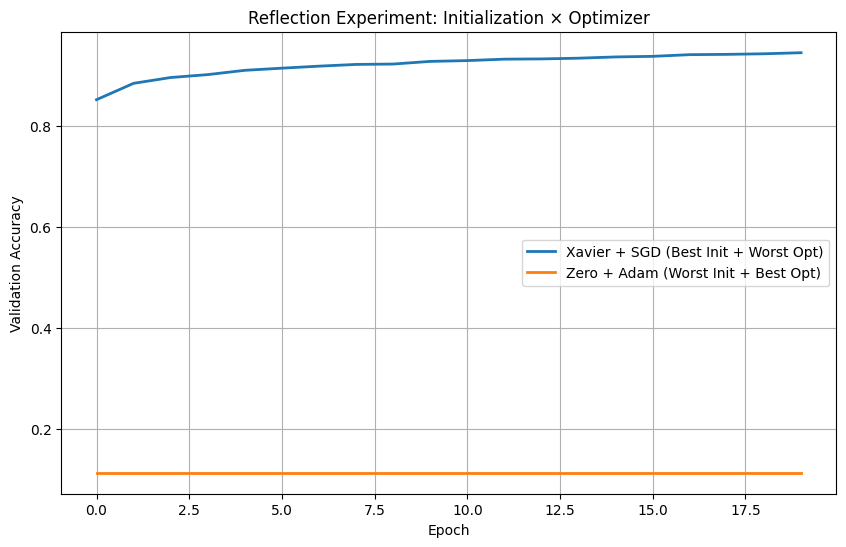

In [ ]:
# ------------------------
# Helper: Xavier Init
# ------------------------
def apply_xavier_init(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

# ------------------------
# Helper: Zero Init
# ------------------------
def apply_zero_init(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.zeros_(layer.weight)
            nn.init.zeros_(layer.bias)

# ------------------------
# Train function (reuse)
# ------------------------
def train_model(model, optimizer, train_loader, val_loader, epochs=20):
    criterion = nn.CrossEntropyLoss()
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            xb = xb.view(xb.size(0), -1)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_acc = evaluate_module(model, train_loader)
        val_acc   = evaluate_module(model, val_loader)

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1:02d} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return train_acc_list, val_acc_list



print("\n=== Experiment 1: Xavier Initialization + SGD Optimizer ===")

model1 = MLP().to(DEVICE)
apply_xavier_init(model1)

optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.0)

train_acc_1, val_acc_1 = train_model(
    model1, optimizer1, train_loader, val_loader, epochs=20
)


print("\n=== Experiment 2: Zero Initialization + Adam Optimizer ===")

model2 = MLP().to(DEVICE)
apply_zero_init(model2)

optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

train_acc_2, val_acc_2 = train_model(
    model2, optimizer2, train_loader, val_loader, epochs=20
)



plt.figure(figsize=(10,6))

plt.plot(val_acc_1, label="Xavier + SGD (Best Init + Worst Opt)", linewidth=2)
plt.plot(val_acc_2, label="Zero + Adam (Worst Init + Best Opt)", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Reflection Experiment: Initialization × Optimizer")
plt.legend()
plt.grid(True)
plt.show()


<font color="red">- From the experiments, I noticed that both initialization and optimization have a big effect on how the model learns. The best initialization method in my tests was Xavier, and the worst by far was Zero initialization. For optimizers, Adam performed the best, while SGD was usually the slowest and least stable.

1. Best Initialization + Worst Optimizer

<font color="red">When I combined Xavier initialization with SGD, the model still managed to learn, but very slowly. Xavier helped stabilize the gradients, so even with a weaker optimizer like SGD, the model eventually improved. The validation accuracy increased, but not as fast and not as high as with Adam.
This showed me that good initialization can make a weak optimizer still work reasonably well, though training is slower and less consistent.

2. Worst Initialization + Best Optimizer

<font color="red">When I combined Zero initialization with Adam, the model basically didn’t learn anything. Even though Adam is normally very strong, it could not fix the symmetry problem caused by all weights starting at zero. All neurons behaved the same, gradients stayed identical, and the network never learned meaningful features.
This showed that a strong optimizer cannot rescue a fundamentally bad initialization.

<font color="red">Overall Conclusion

<font color="red">The results suggest that initialization and

---

optimization interact in important ways. A good optimizer is helpful, but bad initialization can completely break training, no matter which optimizer is used. On the other hand, a good initialization method can still succeed even with a weaker optimizer.
So, initialization seems to have the bigger impact when it is extremely poor (like zero init), while the optimizer mainly affects speed and stability.

## Question 2:  Multidimentional XOR and backpropagation

Given $ d $ bits $b=(b_1, b_2, ... , b_d) \in \{0, 1\}^d$, we define $$XOR(b) = Σ_{i=1}^db_i\ mod\ 2$$

In this question, you will train a feedforward neural network to model the multidimensional XOR problem.




The following function returns the labeled XOR "dataset" for any given $d$ (`dim`)

In [ ]:
def XORData(dim):
  X = np.array(list(itertools.product([0, 1], repeat=dim)))
  Y = X.sum(axis=1)%2
  return X, Y

Implement the following:

1. A linear layer class:`Linear(torch.nn.Module)`\
• You should inherit from `torch.nn.Module`\
• You can not use `torch.nn.LinearLayer` or any other model implemented by PyTorch, only tensors. Wrap every tensor object with `torch.nn.Parameter` (for the optimizer).\
• Use `torch.randn` to initialize the parameter tensors (weights matrix and biases vector)\
• Implement the `forward` method according to the linear model $y = Wx + b$\
• The number of parameters should be defined by `in_features` and `out_features` \
• Make sure to enable gradient computation!

In [ ]:
class Linear(nn.Module):
      def __init__(self, in_features, out_features):
          super().__init__()

          W = torch.randn(out_features, in_features)
          b = torch.randn(out_features)

          self.W = nn.Parameter(W)
          self.b = nn.Parameter(b)

      def forward(self, x):
          return x @ self.W.T + self.b


2. A feedforward neural network:`FFNet(torch.nn.module)`\
• Use the `Linear` class you implemented to construct a network with `in_features` input size, `out_features` output size, and one hidden layer with `hidden_size` neurons.\
• Use the sigmoid activation function on top of the hidden layer neurons.

In [ ]:
class FFNet(nn.Module):
    def __init__(self, in_features, out_features, hidden_size):
        super().__init__()

        self.fc1 = Linear(in_features, hidden_size)

        self.fc2 = Linear(hidden_size, out_features)

        self.activation = torch.sigmoid

    def forward(self, x):
        h = self.activation(self.fc1(x))

        out = self.fc2(h)
        return out


### Exploring the hidden layer
In class we discussed the **Universal Approximation Theorem**. The following question will help us to understand how hard it is to find the optimal weight mentioned in the theorem.

You are given a basic training function:

In [ ]:
loss_func = nn.MSELoss()

def train(net, X, Y, epochs=300):
  steps = X.shape[0]
  for i in range(epochs):
      for j in range(steps):
          data_point = np.random.randint((X.shape[0]))
          x_var = torch.Tensor(X[data_point])
          y_var = torch.Tensor([Y[data_point]])
          optimizer.zero_grad()
          y_hat = net(x_var)
          loss = loss_func(y_hat, y_var)
          loss.backward()
          optimizer.step()
      if(i % 100 == 0):
          print("Epoch:{}, Loss:{}".format(i, loss.detach()))

Using the code above, for each of the dimensions: $d = 2, 3, 4, 5$:
1. Create the corresponding dataset using `XORData`
2. Create models with different hidden layer sizes($1, 2, 3, ..., d,d+const, const*d,...$ etc.) and an optimizer for it using: `optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
`
3. Try to train the different networks on the dataset.
4. Plot the losses for different models on the same grid. Reflect on your findings.

Make sure to create a new `FFNet` and optimizer objects each time you call `train`.



===== Dimension d = 2 =====
Training for hidden size = 1
Training for hidden size = 2
Training for hidden size = 3
Training for hidden size = 2
Training for hidden size = 4
Training for hidden size = 4

===== Dimension d = 3 =====
Training for hidden size = 1
Training for hidden size = 2
Training for hidden size = 3
Training for hidden size = 3
Training for hidden size = 5
Training for hidden size = 6

===== Dimension d = 4 =====
Training for hidden size = 1
Training for hidden size = 2
Training for hidden size = 3
Training for hidden size = 4
Training for hidden size = 6
Training for hidden size = 8

===== Dimension d = 5 =====
Training for hidden size = 1
Training for hidden size = 2
Training for hidden size = 3
Training for hidden size = 5
Training for hidden size = 7
Training for hidden size = 10


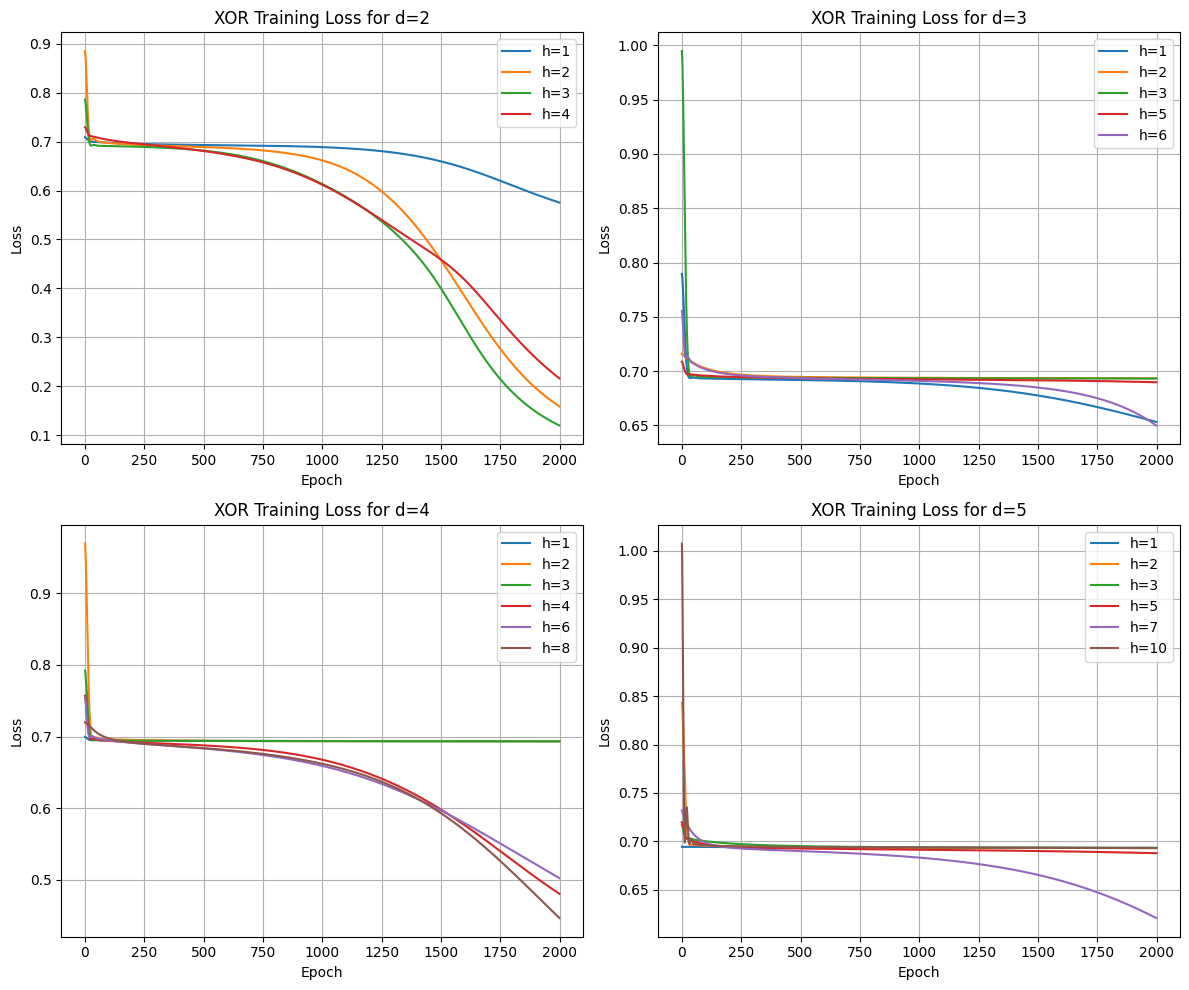

In [ ]:
def train_xor(model, optimizer, X, Y, epochs=2000):
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

    loss_fn = nn.BCEWithLogitsLoss()
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, Y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    return losses

def hidden_sizes_for_dim(d):
    return [1, 2, 3, d, d+2, d*2]

dims = [2, 3, 4, 5]
all_results = {}

for d in dims:
    print(f"\n===== Dimension d = {d} =====")

    X, Y = XORData(d)
    hidden_list = hidden_sizes_for_dim(d)

    results_for_d = {}

    for h in hidden_list:
        print(f"Training for hidden size = {h}")

        model = FFNet(in_features=d, out_features=1, hidden_size=h)
        optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

        losses = train_xor(model, optimizer, X, Y, epochs=2000)
        results_for_d[h] = losses

    all_results[d] = results_for_d


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, d in enumerate(dims):
    ax = axes[idx]
    results = all_results[d]

    for h, losses in results.items():
        ax.plot(losses, label=f"h={h}")

    ax.set_title(f"XOR Training Loss for d={d}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


<font color="red">**Answer the following questions:** </font>

1. For which dimensions were you able to reach a model that converges (loss value is geting close to 0)?

2. What is the number of hidden neurons in that network and how did you find it?

3. What results did you expect and how does it differ from the results you achieved?


<font color="red">Answer for 1:  The model only converged for dimension d = 2. In this case the loss went down close to zero, especially when using a slightly bigger hidden layer. For the higher dimensions (d = 3, 4, and 5), the loss never reached a low value and stayed around the same range, so these models did not fully converge.


<font color="red">Answer for 2:  For d = 2, the network converged when I used around 3 or 4 hidden neurons. I found this by trying several hidden sizes and looking at the loss curves. The hidden layers that made the loss drop all the way down toward zero were the ones that worked, while smaller hidden sizes got stuck and didn’t improve much.


<font color="red">Answer for 3:  I expected that if I increased the hidden size enough, the model would eventually learn XOR in all dimensions, even for d = 3, 4, and 5. But the actual results were different—the model only managed to converge for d = 2, and for the higher dimensions the loss didn’t get close to zero no matter how big the hidden layer was. This showed me that a single hidden layer wasn’t strong enough to solve higher-dimensional XOR.





### Backpropagation

The following part will focus on the computaion of gradients with respect to the model parameters, aimed at understanding the functioning of `loss.backward()`.

Implement the function:`calc_gradients(net, x, loss)` with the following instructions:

- Input: instance of `FFNet` with a hidden layer of size 2, input of size 2 and output of size 1, input vector `x` and `loss` value.

- Output: One dimensional tensor with the gradients of the loss w.r.t each of the parameters, ordered as the corresponding parameters order `net.parameters()` returns (if we would flatten it's output).

1. Compute (by hand) the derivatives w.r.t the second linear layer parameters.
2. Use the chain rule to compute (by hand) the derivatives w.r.t the first linear layer parameters.
3. Implement the final form computations per parameter.
4. Order the gradients as described above.


In [ ]:
def calc_gradients(net, x, y_var, y_hat, loss):
    """
    Manually compute gradients of the loss w.r.t. all parameters in FFNet.

    net: FFNet with:
        - net.fc1.W, net.fc1.b
        - net.fc2.W, net.fc2.b
    x:      input tensor shape (2,)
    y_var:  true label tensor shape (1,)
    y_hat:  model output tensor shape (1,) (logit)
    loss:   scalar loss value (we don't actually need it inside)
    """

    # ----- Extract parameters -----
    W1 = net.fc1.W        # (hidden_size, in_features)
    b1 = net.fc1.b        # (hidden_size,)
    W2 = net.fc2.W        # (out_features, hidden_size)
    b2 = net.fc2.b        # (out_features,)

    # Make sure shapes are 1D where needed
    x = x.view(-1)        # (in_features,)
    y_pred = y_hat.view(-1)   # (1,)
    y_true = y_var.view(-1)   # (1,)

    # ----- Forward pass (recomputed) -----
    # Hidden pre-activation
    z1 = W1 @ x + b1          # (hidden_size,)
    # Hidden activation
    h = torch.sigmoid(z1)     # (hidden_size,)
    # Output (logit)
    z2 = W2 @ h + b2          # (1,)
    y_pred_manual = z2.view(-1)   # (1,)

    # (y_pred_manual should equal y_pred; we just keep consistency)

    # ----- dL/dy (MSE loss) -----
    # L = (y_pred - y_true)^2  => dL/dy = 2 * (y_pred - y_true)
    dL_dy = 2 * (y_pred_manual - y_true)   # shape: (1,)

    # ----- Gradients for layer 2 -----
    # y = W2 @ h + b2
    # dL/dW2 = dL/dy * h^T
    dL_dW2 = dL_dy.unsqueeze(1) @ h.unsqueeze(0)   # (1, hidden_size)
    dL_db2 = dL_dy.clone()                         # (1,)

    # ----- Backprop to hidden -----
    # dL/dh = W2^T @ dL/dy
    dL_dh = W2.t() @ dL_dy.view(-1)                # (hidden_size,)

    # Sigmoid derivative: σ'(z) = σ(z) * (1 - σ(z))
    sig_prime = h * (1 - h)                        # (hidden_size,)
    dL_dz1 = dL_dh * sig_prime                     # (hidden_size,)

    # ----- Gradients for layer 1 -----
    # z1 = W1 @ x + b1  => dL/dW1 = dL/dz1 * x^T
    dL_dW1 = dL_dz1.unsqueeze(1) @ x.unsqueeze(0)  # (hidden_size, in_features)
    dL_db1 = dL_dz1.clone()                        # (hidden_size,)

    # ----- Flatten gradients in SAME ORDER as net.parameters() -----
    # net.parameters() -> [fc1.W, fc1.b, fc2.W, fc2.b]
    grads = torch.cat([
        dL_dW1.reshape(-1),
        dL_db1.reshape(-1),
        dL_dW2.reshape(-1),
        dL_db2.reshape(-1)
    ])

    return grads


Run the following cell to check the correctness of your computation:

In [ ]:
def equal_gradients(net, x, y_var, y_hat, loss):
  grads = []
  for param in net.parameters():
    grads.append(param.grad.view(-1))
  grads = torch.cat(grads)
  return True if torch.sum(grads - calc_gradients(net, x, y_var, y_hat, loss)).round() == 0 else False # Added round because results were very close but not identical

def train_and_compare(net, X, Y, epochs=100):
  steps = X.shape[0]
  for i in range(epochs):
      for j in range(steps):
          data_point = np.random.randint(X.shape[0])
          x_var = torch.Tensor(X[data_point])
          y_var = torch.Tensor([Y[data_point]])
          optimizer.zero_grad()
          y_hat = net(x_var)
          loss = loss_func(y_hat, y_var)
          loss.backward()
          if not equal_gradients(net, x_var, y_var, y_hat, loss.item()):
            print("Wrong gradients computation!")
            return
          optimizer.step()
  print("Correct gradients computation!")

model = FFNet(2, 1, 2)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
X, Y = XORData(2)


train_and_compare(model, X, Y)

Correct gradients computation!
